# Finite-Sample Bounds for Two-Distribution Hypotheis Tests
Experiments for the paper "Finite-Sample Bounds for Two-Distribution Hypotheis Tests", accepted to DSAA 2023.

## Imports

We'll start by importing the necessary libraries.

In [ ]:
import numpy as np
import copy
import scipy
from scipy import special
import scipy.stats
from scipy.optimize import minimize
import matplotlib.pyplot as plt
from random import shuffle
import math
from mpmath import *
from scipy.stats import norm

## General Compute Bound function

Here we define a general function used to compute a bound using Corollary 1 in the paper. When using Corollary 1, you'll want to determine what `n`, `mg_hat_x`, `script_x`, and `p_x` are for your use case.



In [ ]:
def compute_bound(n, mg_hat_x, script_x, p_x, delta=0.01, should_print=True):
  """
  Computes the bound using Corollary 1.
  n: Total number of samples
  mg_hat_x: Number of samples x_s where g(x_s) > g(x)
  script_x: Size of sample space (e.g. number of traps, datasets)
  p_x: The probability of selecting x from the space of possible instances.
  delta: The delta parameter
  should_print: Whether the function should print out values used in the calculation
  """

  fg_hat_x = mg_hat_x / n
  nu_hat_x = n/mg_hat_x
  z = np.abs(scipy.stats.norm.ppf(delta/2))
  bound = script_x * (1 + np.log(script_x)) * p_x * (1/nu_hat_x + z/(2 * np.sqrt(n))) * (1 - delta) + delta

  if should_print:
    print(f'sample size: {n}')
    print(f'mg_hat_x: {mg_hat_x}')
    print(f'fg_hat_x: {fg_hat_x}')
    print(f'nu_hat_x: {nu_hat_x}')
    print(f'p_x: {p_x}')
    print(f'\nPr(SC(X) > SC(x)) <= {bound}\n')

  return bound

## Intention Perception in Artificial Agents

Let's see how the bound can be used to detect whether a gopher trap is likely to be designed as opposed to being random configuration of trap pieces. In the paper [The Gopher's Gambit](https://par.nsf.gov/servlets/purl/10315004), a gopher is equipped with an intention-pereption algorithm that helps it determine whether a trap is designed or random. In particular, prior work calculated the probability $Pr(SC(X) \geq SC(x))$ that a trap $x$ was designed by using combinatorics. By using `compute_bound`, we give a bound on $Pr(SC(X) \geq SC(x))$ using a finite sample instead.

### Setup

We'll start by defining some constants that we'll use in the experiment.

`NUM_TRAPS_GREATER_OR_EQUAL_RATIO[i]` is the number of traps with $g(x)$ values greater than or equal to `GS[i]`. `NUM_TRAPS_GREATER_OR_EQUAL_RATIO` was precomputed in Table 4 on Page 11 of this [paper](https://par.nsf.gov/servlets/purl/10315004). Typically, this distribution won't be available, as we would otherwise simply use the actual value of $M_g(x)$ instead of the estimate. However, in our case, we simply use this knowledge as a tool to more quickly generate samples.

In [ ]:
NUM_TRAPS_GREATER_OR_EQUAL_RATIO = [427929800129788411, 354394707075243198, 123453353582343198, 102193295525793198, 101346901331553198, 101327843325852198, 101327577622082748, 18317428758242748, 12289201862932377, 12103878714006177, 1272268411781292, 689654429107497, 689623309037907, 677046035997297, 41696845623225, 18559182512862, 919349539299, 616034679885, 615255422625, 239164711182, 6417454230, 3925431153, 1459677645, 26456355, 22595625, 17067672, 10561401, 4297158, 26730, 3]
NUM_TRAPS_GREATER_OR_EQUAL_RATIO = np.array(NUM_TRAPS_GREATER_OR_EQUAL_RATIO)
GS = [0/9, 1/9, 1/8, 1/7, 1/6, 1/5, 2/9, 1/4, 2/7, 1/3, 3/8, 2/5, 3/7, 4/9, 1/2, 5/9, 4/7, 3/5, 5/8, 2/3, 5/7, 3/4, 7/9, 4/5, 5/6, 6/7, 7/8, 8/9, 9/9, 10/9]

`NUM_POSS_TRAPS` is the total number of possible gopher traps.

In [ ]:
NUM_POSS_TRAPS = NUM_TRAPS_GREATER_OR_EQUAL_RATIO[0]

Let's now calculate number of traps with each exact ratio. `NUM_TRAPS_WITH_RATIO[i]` is the number of traps with $g(x)$ values equal to `GS[i]`.

In [ ]:
NUM_TRAPS_WITH_RATIO = np.copy(NUM_TRAPS_GREATER_OR_EQUAL_RATIO)
for i in range(len(NUM_TRAPS_GREATER_OR_EQUAL_RATIO) - 1):
  NUM_TRAPS_WITH_RATIO[i] = NUM_TRAPS_GREATER_OR_EQUAL_RATIO[i] - NUM_TRAPS_GREATER_OR_EQUAL_RATIO[i + 1]
print(f'NUM_TRAPS_WITH_RATIO: \n{NUM_TRAPS_WITH_RATIO}')

NUM_TRAPS_WITH_RATIO: 
[ 73535093054545213 230941353492900000  21260058056550000
    846394194240000     19058005701000       265703769450
  83010148863840000   6028226895310371    185323148926200
  10831610302224885    582613982673795        31120069590
     12577273040610    635349190374072     23137663110363
     17639832973563       303314859414          779257260
       376090711443       232747256952         2492023077
         2465753508         1433221290            3860730
            5527953            6506271            6264243
            4270428              26727                  3]


Finally, we calculate the probability of selecting a trap with a given $g(x)$ value. This will help us sample according to the true distribution.

In [ ]:
PROBS = NUM_TRAPS_WITH_RATIO/NUM_POSS_TRAPS
print(f'PROBS: \n{PROBS}')

PROBS: 
[1.71839150e-01 5.39671118e-01 4.96811815e-02 1.97788094e-03
 4.45353553e-05 6.20905039e-07 1.93980762e-01 1.40869528e-02
 4.33069043e-04 2.53116523e-02 1.36147093e-03 7.27223708e-08
 2.93909726e-05 1.48470424e-03 5.40688288e-05 4.12213241e-05
 7.08795834e-07 1.82099321e-09 8.78860765e-07 5.43891210e-07
 5.82343898e-09 5.76205141e-09 3.34919720e-09 9.02187695e-12
 1.29178968e-11 1.52040615e-11 1.46384828e-11 9.97927230e-12
 6.24565057e-14 7.01049564e-18]


### Functions

`get_mg_gopher` gets a sample of `n` elements from the overall space of elements and returns the $\hat{M_g}(x)$, the number of these elements with $g(x)$ values greater than or equal to $x$, the trap being evaluated.

In [ ]:
def get_mg_gopher(n, gs_idx, modified=False, multisample=False):
  """
  n: Total number of samples
  gs_idx: The index in the GS array (see Setup section) that corresponds to g(x),
    the number of coherent connections per nonempty cell in this configuration
  modified: whether we should set mg_x to be 1 if mg_x was calculated to be 0
    (to avoid division by 0 error)
  multisample: whether we should take multiple samples to reduce the RAM required to
    store the sample array. If True, n must be a multiple of 1,000,000.
  """
  BATCH_SIZE = 1000000
  MAX_RAM_SIZE = 500000000

  if multisample and n % BATCH_SIZE != 0:
    print(f"WARNING: multisample is True but n is not a multiple of {BATCH_SIZE}.")

  # Automatically turn on multisample if over MAX_RAM_SIZE
  if n > MAX_RAM_SIZE:
    if n % BATCH_SIZE == 0:
      multisample = True
    else:
      print(f"WARNING: n > {MAX_RAM_SIZE} but n is not a multiple of {BATCH_SIZE}.")

  if multisample:
    mg_hat_x = multisample_gopher(n, gs_idx)
  else:
    mg_hat_x = sample_gopher(n, gs_idx)

  if modified and mg_hat_x == 0:
    mg_hat_x = 1

  return mg_hat_x

`sample_gopher` is a helper function which generates the actual sample of `n` traps and computes the number of these traps $x_s$ where $g(x_s) > g(x)$.  `multisample_gopher` is the same as `sample_gopher` but does so in batches so that we can avoid running out of memory for large sample sizes.

In [ ]:
def sample_gopher(n, gs_idx):
  """
  Generate a sample of n traps, and determine the number of these traps whose
   g(x) values are greater than or equal to that of x.
  n: The number of traps to sample
  gs_idx: The index in the GS array that corresponds to the g(x) value of the trap
    we're analyzing.
  """
  sample = np.random.choice(len(NUM_TRAPS_WITH_RATIO), n, p=PROBS)
  mg_hat_x = len(sample[sample >= gs_idx])
  return mg_hat_x

def multisample_gopher(n, gs_idx):
  """
  Same as sample_gopher, but uses batches in order to avoid running out of memory.
  n: The number of traps to sample
  gs_idx: The index in the GS array that corresponds to the g(x) value of the trap
    we're analyzing.
  """
  BATCH_SIZE = 1000000
  num_samples = n // BATCH_SIZE
  mg_hat_x = 0

  for i in range(num_samples):
    mg_hat_x += sample_gopher(n, gs_idx)

  return mg_hat_x

`compute_real_bound_gopher` computes the true bound for a gopher trap.

In [ ]:
def compute_real_bound_gopher(gs_idx, shouldPrint=True):
  """
  gs_idx: The index in the GS array that corresponds to the g(x) value of the trap
    we're analyzing.
  should_print: Whether the function should print out values used in the calculation
  """
  mg_x = NUM_TRAPS_GREATER_OR_EQUAL_RATIO[gs_idx]
  fg_x = mg_x / NUM_POSS_TRAPS
  nu_x = 1/fg_x
  kardis = NUM_POSS_TRAPS * (1 + np.log(NUM_POSS_TRAPS)) * (1/NUM_POSS_TRAPS) * fg_x
  if shouldPrint:
    print(f'mg_x: {mg_x}')
    print(f'fg_x: {fg_x}')
    print(f'nu_x: {nu_x}')
    print(f'script_x : {NUM_POSS_TRAPS}')
    print(f'\nkardis (real value): {kardis}')
  return kardis

### Experiments

Let's try calculating the bound on a trap $x$ with $g(x) = 4/4 = 1$. If we set $\alpha = 0.05$, then the results are statistically significant, that is, we reject the null hypothesis that this trap was randomly generated.

In [ ]:
ratio_gopher = 4/4
n_gopher=10_000_000
mg_hat_gopher = get_mg_gopher(n=10000000, gs_idx=GS.index(ratio_gopher), modified=True)
compute_bound(n_gopher, mg_hat_gopher, script_x=NUM_POSS_TRAPS, p_x=1/NUM_POSS_TRAPS)

sample size: 10000000
mg_hat_x: 1
fg_hat_x: 1e-07
nu_hat_x: 10000000.0
p_x: 2.3368318815298826e-18

Pr(SC(X) > SC(x)) <= 0.026776392933229226



0.026776392933229226

This is consistent with the results we get when we calculate the true value of $\nu(x)$.

In [ ]:
compute_real_bound_gopher(GS.index(4/4))

mg_x: 26730
fg_x: 6.246351619329376e-14
nu_x: 16009345309756.395
script_x : 427929800129788411

kardis (real value): 2.598340828672189e-12


2.598340828672189e-12

In [ ]:
compute_real_bound_gopher(GS.index(1/9))

mg_x: 354394707075243198
fg_x: 0.8281608501388721
nu_x: 1.2074948964712744
script_x : 427929800129788411

kardis (real value): 34.44961604410494


34.44961604410494

### Bound for Varying $\delta$ and $n$

We use [this post](https://learnsharewithdp.wordpress.com/2020/05/08/latex-matplotlib-google-colab/) to install latex in Google Colab.

In [ ]:
! sudo apt-get install texlive-latex-recommended
! sudo apt-get install dvipng texlive-latex-extra texlive-fonts-recommended
! wget http://mirrors.ctan.org/macros/latex/contrib/type1cm.zip
! unzip type1cm.zip -d /tmp/type1cm
! cd /tmp/type1cm/type1cm/ && sudo latex type1cm.ins
! sudo mkdir /usr/share/texmf/tex/latex/type1cm
! sudo cp /tmp/type1cm/type1cm/type1cm.sty /usr/share/texmf/tex/latex/type1cm
! sudo texhash

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  dvisvgm fonts-droid-fallback fonts-lmodern fonts-noto-mono fonts-urw-base35
  libfontenc1 libgs9 libgs9-common libharfbuzz-icu0 libidn11 libijs-0.35
  libjbig2dec0 libkpathsea6 libptexenc1 libsynctex2 libteckit0 libtexlua53
  libtexluajit2 libwoff1 libzzip-0-13 lmodern poppler-data t1utils tex-common
  texlive-base texlive-binaries texlive-latex-base xfonts-encodings
  xfonts-utils
Suggested packages:
  fonts-noto fonts-freefont-otf | fonts-freefont-ttf fonts-texgyre
  poppler-utils ghostscript fonts-japanese-mincho | fonts-ipafont-mincho
  fonts-japanese-gothic | fonts-ipafont-gothic fonts-arphic-ukai
  fonts-arphic-uming fonts-nanum debhelper gv | postscript-viewer perl-tk xpdf
  | pdf-viewer xzdec texlive-latex-base-doc texlive-latex-recommended-doc
  texlive-luatex texlive-pstricks
The following NEW packages will be installed:
  dvis

In [ ]:
!apt install cm-super

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following additional packages will be installed:
  cm-super-minimal pfb2t1c2pfb
The following NEW packages will be installed:
  cm-super cm-super-minimal pfb2t1c2pfb
0 upgraded, 3 newly installed, 0 to remove and 24 not upgraded.
Need to get 24.5 MB of archives.
After this operation, 59.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu focal/universe amd64 cm-super-minimal all 0.3.4-15 [5,811 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal/universe amd64 pfb2t1c2pfb amd64 0.3-11 [9,342 B]
Get:3 http://archive.ubuntu.com/ubuntu focal/universe amd64 cm-super all 0.3.4-15 [18.7 MB]
Fetched 24.5 MB in 2s (9,848 kB/s)
Selecting previously unselected package cm-super-minimal.
(Reading database ... 152944 files and directories currently installed.)
Preparing to unpack .../cm-super-minimal_0.3.4-15_all.deb ...
Unpacking cm-super-minimal (0.3.4-15) ...
Selecting 

In [ ]:
plt.style.use("seaborn")
plt.rcParams['text.usetex'] = True
plt.rcParams['figure.figsize'] = [6.4, 4.8]

<ipython-input-17-f558d5f23b3b>:1: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn")


`boundForVaryingDeltaN` creates graphs similar to Figure 2 in the paper. It shows the effect of various values for the $\delta$ parameter and $n$ on the error of the resulting bound.

In [ ]:
def boundForVaryingDeltaN(ratio, deltas=[delta for delta in np.arange(.000000001, .05, .0001)], ns=[100000, 1000000, 10000000, 100000000], filename=None, title=None):
  """
  Creates a graph displaying the effects of using different values for delta and n
  on the resulting bound.
  ratio: The ratio of coherent connections to nonempty cells in the gopher trap
  deltas: The list of delta parameters to calculate the bound for and display
  ns: The list of sample sizes to calculate the bound for and display
  filename: Filename to save the graph to
  title: Title of the graph
  """
  real_bound = compute_real_bound_gopher(GS.index(ratio))
  for n in ns:
    mg_hat_gopher = get_mg_gopher(n=n, gs_idx=GS.index(ratio), modified=True)
    ps = [compute_bound(n, mg_hat_gopher, script_x=NUM_POSS_TRAPS, p_x=1/NUM_POSS_TRAPS, delta=delta, should_print=False) - real_bound for delta in deltas]
    plt.plot(deltas, ps, label=f"n = {n}")
    print(f"calculated ps for n = {n}")
  plt.xlabel(r'$\delta$', fontsize=16)
  plt.ylabel(r'Error in $\Pr(SC(X) \geq SC(x))$', fontsize=16)
  if title == None:
      title = r'Error in $\Pr(SC(X) \geq SC(x))$ for varying values of \textit{n} and $\delta$'
  plt.title(title, fontsize=16)
  plt.legend()
  if filename == None:
    filename = f"ratio={ratio}varying-delta+n_fixed_label.pdf"
  plt.savefig(filename, bbox_inches='tight')
  plt.show()

mg_x: 26730
fg_x: 6.246351619329376e-14
nu_x: 16009345309756.395
script_x : 427929800129788411

kardis (real value): 2.598340828672189e-12
calculated ps for n = 100000
calculated ps for n = 1000000
calculated ps for n = 10000000
calculated ps for n = 100000000


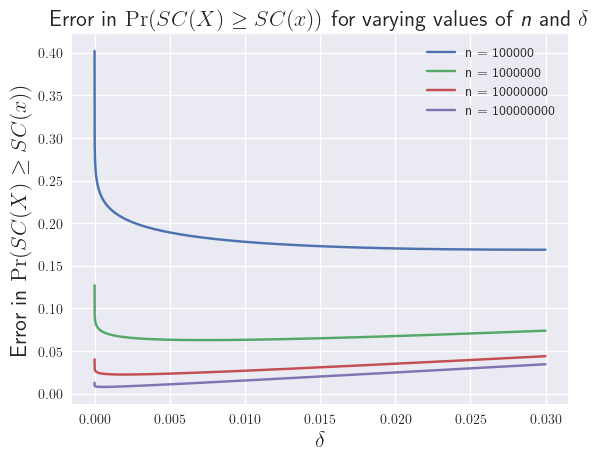

In [ ]:
boundForVaryingDeltaN(4/4, deltas=[delta for delta in np.arange (.000000001, .03, .00001)])

## Identifying Bias in Data

Let's see how the bound can be used for the bias in data experiments. Prior work in the paper [Identifying Bias in Data Using Two-Distribution Hypothesis Tests](https://dl.acm.org/doi/pdf/10.1145/3514094.3534169) calculated the true value of $Pr(SC(X) \geq SC(x))$ by using combinatorics. Similarly to above, we  now use `compute_bound` to compute a bound on $Pr(SC(X) \geq SC(x))$ using a finite sample of other possible datasets.

### Functions

`get_mg_bias` calculates $\hat{M_g}(x)$ for a given dataset $x$.

To do so, it uses vectors which correspond to the distribution of the dataset across categories. For instance, we could have a dataset of adults, with a male:female ratio of 1:1. Assume that we then found all adults in the dataset who were predicted to make above a certain income level. If we had 1000 adults in the dataset, we'd expect to have 500 males and 500 females, for an expected vector of [500, 500]. However, the actual vector could vary.

To calculate $\hat{M_g}(x)$, `get_mg_bias` first calculates how much $x$'s vector differs from the expected vector. It then counts the number of sampled datasets whose vectors differ more from the expected vector than $x$'s vector differs from the expected vector.

In [ ]:
def get_mg_bias(n, actual_vec, expected_vec):
  """
  Given an actual vector and expected vector, takes n samples and calculates
  the number of these samples that are have more extreme differences from the
  expected_vec than actual_vec does.
  n: Total number of samples
  actual_vec: The vector that corresponds to the dataset we're evaluating.
  expected_vec: The vector that we'd expect if the dataset wasn't biased.
  """
  g_x = np.sum(np.abs(actual_vec-expected_vec))
  num_entries = np.sum(actual_vec)
  num_categories = len(actual_vec)
  hypothesis = [i/sum(expected_vec) for i in expected_vec]

  mg_hat_x = 0
  for i in range(n):
    sample = np.array(sample_bias(num_entries, num_categories))
    distance_vec = sample - expected_vec
    if np.sum(np.abs(distance_vec)) >= g_x:
      mg_hat_x += 1

  return mg_hat_x

`sample_bias` is a helper function for `get_mg_bias` which generates an array representing the number of rows assigned to each of a given number of categories `num_categories` for a dataset of a given size `n`. E.g. [200, 200, 200] for a dataset of 600 rows where an equal number are labeled as low, medium, and high recidivism risk.

In [ ]:
def sample_bias(n, num_categories):
  """
  n: The number of rows in the dataset. (e.g. the number of people in the COMPAS dataset)
  num_categories: The number of categories that the rows are labeled as (e.g. low, medium, high recidivism risk)
  """
  x = []
  for i in range(num_categories):
    sum_of_previous = sum(x)
    if i == num_categories - 1:
      x.append(n-sum_of_previous)
    else:
      x.append(np.random.choice(n-sum_of_previous))
  shuffle(x)
  return x

`get_script_x_bias` and `get_p_x_bias` are helper functions which calculate $\mathcal{X}$ and $p(x)$ respectively.

In [ ]:
def get_script_x_bias(actual_vec, expected_vec):
  """
  Calculates script_x, the sample space,
   for a given actual vector and expected vector.
  actual_vec: The vector that corresponds to the dataset we're evaluating.
  expected_vec: The vector that we'd expect if the dataset wasn't biased.
  """
  num_entries = np.sum(actual_vec)
  num_categories = len(actual_vec)
  return scipy.special.comb(num_entries+num_categories-1, num_categories-1)

In [ ]:
def get_p_x_bias(actual_vec, expected_vec):
  """
  Calculates p_x for a given actual vector and expected vector.
  actual_vec: The vector that corresponds to the dataset we're evaluating.
  expected_vec: The vector that we'd expect if the dataset wasn't biased.
  """
  num_entries = np.sum(actual_vec)
  num_categories = len(actual_vec)
  hypothesis = [i/sum(expected_vec) for i in expected_vec]
  return (mpf(math.factorial(num_entries)) / np.prod([mpf(math.factorial(x)) for x in actual_vec])) * np.prod([mpf(hypothesis[i])**mpf(int(actual_vec[i])) for i in range(len(actual_vec))])


### Experiments

Let's try an example.

In [ ]:
actual_vec_bias = np.array([1623, 1705, 2479])
expected_vec_bias = np.array([621, 1295, 3891])
n_bias = 10_000_000

mg_hat_bias = get_mg_bias(n_bias, actual_vec_bias, expected_vec_bias)
script_x_bias = get_script_x_bias(actual_vec_bias, expected_vec_bias)
p_x_bias = get_p_x_bias(actual_vec_bias, expected_vec_bias)

compute_bound(n=n_bias, mg_hat_x=mg_hat_bias, script_x=script_x_bias, p_x=p_x_bias, delta=0.01, should_print=True)

sample size: 10000000
mg_hat_x: 7505778
fg_hat_x: 0.7505778
nu_hat_x: 1.3323069240790228
p_x: 4.85799124110438e-400

Pr(SC(X) > SC(x)) <= 0.01



mpf('0.01')

## Detecting Student Cheating

Now, let's try computing the bound for a scenario where we don't already know the real bound at all. In this scenario, we have a set of student scantrons and suspect that some group of students is cheating. To test our hypothesis, we compare a student to everyone who we think they've been cheating off of, and determine if the number of wrong answers that they got the same deviates significantly from the number of wrong answers that are expected to be the same due to randomness.

### Functions

We first give a general function that returns the bound for the scantron example, given the student who we believe is cheating, a suspect who we think they are cheating off of, and information about the size of the scantrons.

In [ ]:
def compute_bound_scantron(n, x, suspect, answer_key, num_choices, num_questions, prob_correct=0.92, delta=0.01, should_print=True):
  """
  n: Total number of samples
  x: The student who we suspect is cheating
  suspect: Student who we think that student x is cheating off of
  answer_key: Answer key for the scantron
  num_choices: Number of choices for each question
    (e.g. 4 if we have A, B, C and D)
  num_questions: Number of questions in the scantron.
  prob_correct: The average percentage of questions that a typical student gets correct
  delta: The delta parameter (see paper for more details)
  should_print: Whether the function should print out values used in the calculation
  """
  mg_scantron = get_mg_scantron(n, suspect, answer_key, num_choices, num_questions)
  script_x_scantron = get_script_x_scantron(num_choices, num_questions)
  p_x_scantron = get_p_x_scantron(answer_key, x, prob_correct, num_choices)
  return compute_bound(n, mg_scantron, script_x_scantron, p_x_scantron, delta=delta, should_print=should_print)

In [ ]:
def get_mg_scantron(n, suspect, answer_key, num_choices, num_questions):
  """
  n: Total number of samples
  suspect: Student who we think that student x is cheating off of
  answer_key: Answer key for the scantron
  num_choices: Number of choices for each question
    (e.g. 4 if we have A, B, C and D)
  num_questions: Number of questions in the scantron.
  """
  mg_hat_x = 0
  g_x = get_g_x_scantron(answer_key, suspect, x, num_choices)
  for i in range(n):
    sample = np.random.choice(['A', 'B', 'C', 'D', 'E'][:num_choices], num_questions)
    sample_g_x = get_g_x_scantron(answer_key, suspect, sample, num_choices)
    if sample_g_x >= g_x:
      mg_hat_x += 1
  if mg_hat_x == 0:
    mg_hat_x = 1#e-3
  return mg_hat_x

In [ ]:
def get_g_x_scantron(key, student1, student2, num_choices):
  """
  Calculates g(x) for a scantron example.
  key: A numpy array representing the answer key
  student1: A numpy array represneting the scantron for the first student
  student2: A numpy array represneting the scantron for the second student
  num_choices: The number of answer choices for each question on the scantron.
  """
  key, student1, student2 = np.array(key), np.array(student1), np.array(student2)
  both_wrong = np.logical_and(student1 != key, student2 != key)
  num_both_wrong = np.sum(both_wrong)
  same_answers = student1 == student2
  num_same_wrong = np.sum(np.logical_and(both_wrong, same_answers))
  return num_same_wrong - num_both_wrong / num_choices

In [ ]:
def get_script_x_scantron(num_choices, num_questions):
  """
  Calculates script x, for a scantron example.
  num_choices: The number of answer choices for each question on the scantron.
  num_questions: Number of questions in the scantron.
  """
  return float(num_choices ** num_questions)

In [ ]:
def get_p_x_scantron(key, x, prob_correct, num_choices):
  """
  Calculates p(x) for a scantron example.
  key: A numpy array representing the answer key
  x: A numpy array represneting the scantron for the student who we believe is cheating.
  prob_correct: Probability of answering a single question correctly.
  num_questions: Number of questions in the scantron.
  """
  num_wrong = sum(np.array(key) != np.array(x))
  num_correct = sum(np.array(key) == np.array(x))
  return (prob_correct ** num_correct) * ((1 - prob_correct)/(num_choices - 1)) ** num_wrong

In [ ]:
def compute_bound_scantron_group(n, x, suspects, answer_key, num_choices, num_questions, prob_correct=0.92, delta=0.01, should_print=True):
  """
  Same as compute_bound_scantron, but computes the bound when we suspect that
  the student is cheating off of multiple other students, as opposed to just one.
  suspects: Same as compute_bound, but with a list of suspects instead of just one.
  """
  bound = 0
  for suspect in suspects:
    bound += compute_bound_scantron(n, x, suspect, answer_key, num_choices, num_questions, prob_correct=prob_correct, delta=delta, should_print=should_print)
  if should_print:
    print(f"Final bound is {bound}")
  return bound

### Experiments

Let's try a few examples. In this example, we have a 20 question scantron where each question has 4 choices, A, B, C and D. Both the student and the person who we suspected they cheated off of have the same exact scantron, and therefore get the same 10 questions wrong.



In [ ]:
n_scantron = 1000
num_questions = 20
num_choices = 4
x = ['A'] * 10 + ['B'] * 10
suspect = x
answer_key = ['A'] * num_questions

compute_bound_scantron(n_scantron, x, suspect, answer_key, num_choices, num_questions)

sample size: 1000
mg_hat_x: 1
fg_hat_x: 0.001
nu_hat_x: 1000.0
p_x: 7.898881457139347e-17

Pr(SC(X) > SC(x)) <= 0.010103061339286032



0.010103061339286032

In this second more extreme example, we have a 50 question scantron, and both the student and person who we suspect they cheated off of have the get all 50 questions wrong in the same way.

In [ ]:
answer_key = ['A'] * 50
x = ['B'] * 50
suspect = x
compute_bound_scantron(100000, x, suspect, answer_key, num_choices=2, num_questions=50)

sample size: 100000
mg_hat_x: 1
fg_hat_x: 1e-05
nu_hat_x: 100000.0
p_x: 1.4272476927059242e-55

Pr(SC(X) > SC(x)) <= 0.01



0.01

In [ ]:
answer_key = ['A'] * 50
x = ['A'] * 30 + ['B'] * 20
suspect1 = x

compute_bound_scantron(10_000_000, x, suspect1, answer_key, num_choices=5, num_questions=50)

sample size: 10000000
mg_hat_x: 1
fg_hat_x: 1e-07
nu_hat_x: 10000000.0
p_x: 8.594779388231022e-36

Pr(SC(X) > SC(x)) <= 0.03508254912414265



0.03508254912414265

In [ ]:
answer_key = ['A'] * 50
x = ['A'] * 30 + ['B'] * 20
suspect1 = ['A'] * 30 + ['B'] * 15 + ['C'] * 5
suspect2 = x

compute_bound_scantron_group(10_000_000, x, [suspect1, suspect2], answer_key, num_choices=5, num_questions=50)

sample size: 10000000
mg_hat_x: 3
fg_hat_x: 3e-07
nu_hat_x: 3333333.3333333335
p_x: 8.594779388231022e-36

Pr(SC(X) > SC(x)) <= 0.035094863374020534

sample size: 10000000
mg_hat_x: 1
fg_hat_x: 1e-07
nu_hat_x: 10000000.0
p_x: 8.594779388231022e-36

Pr(SC(X) > SC(x)) <= 0.03508254912414265

Final bound is 0.07017741249816319


0.07017741249816319